# Session 10

## Cloning the repo

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
%cd /content/drive/MyDrive/Github/ERA-v1

/content/drive/MyDrive/Github/ERA-v1


In [3]:
! git config --global user.email "me18b059@smail.iitm.ac.in"
! git stash push --include-untracked
! git stash drop
! git pull

^C
No stash entries found.
error: You have not concluded your merge (MERGE_HEAD exists).
hint: Please, commit your changes before merging.
fatal: Exiting because of unfinished merge.


In [4]:
%cd S12/

/content/drive/MyDrive/Github/ERA-v1/S10


# CIFAR-10 dataset classification

The CIFAR-10 dataset consists of 60000 32x32 colour images in 10 classes, with 6000 images per class. There are 50000 training images and 10000 test images.

The dataset is divided into five training batches and one test batch, each with 10000 images. The test batch contains exactly 1000 randomly-selected images from each class. The training batches contain the remaining images in random order, but some training batches may contain more images from one class than another. Between them, the training batches contain exactly 5000 images from each class.

# Importing basic dependencies

In [5]:
!pip install torchmetrics
!pip install torch_lr_finder
!pip install pytorch_lightning

In [145]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [146]:
# del model
import torch
import torch.nn as nn
import torch.optim as optim
from Utilities.model import Net
from Utilities.utils import train, test
import torch.nn.functional as F
from torchsummary import summary
from Utilities import config

torch.manual_seed(config.SEED)

# Model Initialization & Summary

In [148]:
criterion = F.cross_entropy

model = Net(
    num_classes=config.NUM_CLASSES, 
    dropout_percentage=config.DROPOUT_PERCENTAGE, 
    norm=config.LAYER_NORM, 
    criterion=criterion, 
    learning_rate=config.LEARNING_RATE, 
    weight_decay=config.WEIGHT_DECAY)

summary(model.to(config.ACCELERATOR), input_size=config.INPUT_SIZE)

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 64, 32, 32]           1,792
       BatchNorm2d-2           [-1, 64, 32, 32]             128
              ReLU-3           [-1, 64, 32, 32]               0
           Dropout-4           [-1, 64, 32, 32]               0
            Conv2d-5          [-1, 128, 32, 32]          73,856
         MaxPool2d-6          [-1, 128, 16, 16]               0
       BatchNorm2d-7          [-1, 128, 16, 16]             256
              ReLU-8          [-1, 128, 16, 16]               0
           Dropout-9          [-1, 128, 16, 16]               0
           Conv2d-10          [-1, 128, 16, 16]         147,584
      BatchNorm2d-11          [-1, 128, 16, 16]             256
             ReLU-12          [-1, 128, 16, 16]               0
          Dropout-13          [-1, 128, 16, 16]               0
           Conv2d-14          [-1, 128,

# Dataset & Dataloaders

In [149]:
from Utilities.transforms import train_transforms, test_transforms

In [150]:
from Utilities.dataset import CIFAR10DataModule

kwargs = {'batch_size': config.BATCH_SIZE, 
          'shuffle': config.SHUFFLE, 
          'num_workers': config.NUM_WORKERS, 
          'pin_memory': config.PIN_MEMORY}
data_module = CIFAR10DataModule(train_transforms=train_transforms, val_transforms=test_transforms, **kwargs)

In [151]:
# Call the setup() method before train_dataloader()
data_module.setup(stage=None)

# Now you can call train_dataloader()
train_loader = data_module.train_dataloader()

# Data Exploration

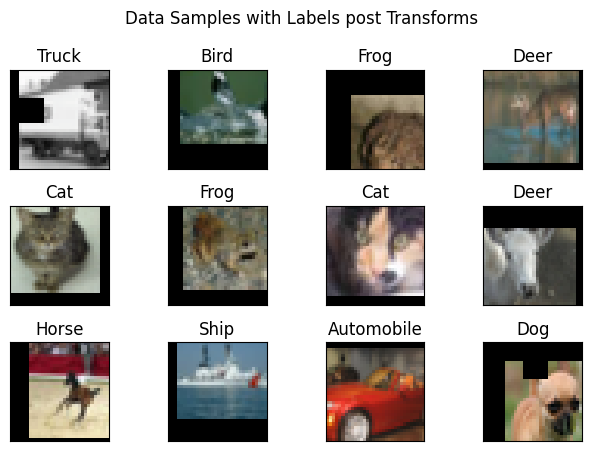

In [14]:
from Utilities.visualize import plot_data_samples, plot_class_label_counts

# plot_class_label_counts(train_loader, classes=config.CLASSES)
plot_data_samples(train_loader, classes=config.CLASSES)

# Training

 78%|███████▊  | 155/200 [03:15<00:56,  1.26s/it]

Stopping early, the loss has diverged
Learning rate search finished. See the graph with {finder_name}.plot()


LR suggestion: steepest gradient
Suggested LR: 1.74E-03


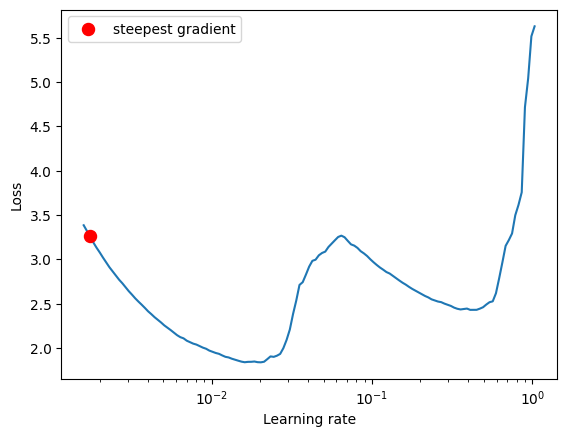

In [100]:
from torch_lr_finder import LRFinder


lr_finder = LRFinder(model, optimizer=model.get_only_optimizer, criterion=model.criterion, device=config.ACCELERATOR)
lr_finder.range_test(train_loader, end_lr=10, num_iter=200, step_mode="exp")
_, best_lr = lr_finder.plot() # to inspect the loss-learning rate graph
lr_finder.reset() # to reset the model and optimizer to their initial state


model.learning_rate = best_lr
model.configure_optimizers()

Trainer already configured with model summary callbacks: [<class 'pytorch_lightning.callbacks.model_summary.ModelSummary'>]. Skipping setting a default `ModelSummary` callback.
GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Files already downloaded and verified
Files already downloaded and verified


100%|██████████| 30/30 [00:34<00:00,  1.16s/it]


Learning rate search finished. See the graph with {finder_name}.plot()
LR suggestion: steepest gradient
Suggested LR: 1.74E-03


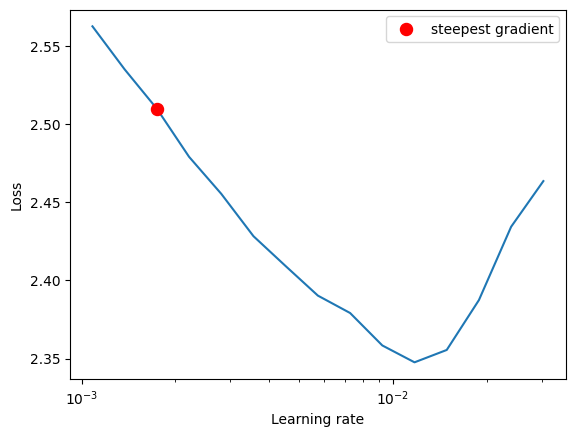

LRFinder Best LR:  0.0017433288221999881
Sanity Checking DataLoader 0: 100%|██████████| 2/2 [00:01<00:00,  1.05it/s]
Epoch: 0, Val Loss: 2.302377700805664, Val Accuracy: 0.1044921875
{'train_loss_epoch': [], 'train_acc_epoch': [], 'val_loss_epoch': [tensor(2.3024)], 'val_acc_epoch': [tensor(0.1045)], 'test_loss_epoch': [], 'test_acc_epoch': []}
Epoch 0: 100%|██████████| 98/98 [01:50<00:00,  1.13s/it, v_num=16, train_loss_step=1.470, train_acc_step=0.426]
Epoch: 0, Val Loss: 1.652285099029541, Val Accuracy: 0.40220001339912415
{'train_loss_epoch': [], 'train_acc_epoch': [], 'val_loss_epoch': [tensor(2.3024), tensor(1.6523)], 'val_acc_epoch': [tensor(0.1045), tensor(0.4022)], 'test_loss_epoch': [], 'test_acc_epoch': []}
Epoch 0: 100%|██████████| 98/98 [02:02<00:00,  1.25s/it, v_num=16, train_loss_step=1.470, train_acc_step=0.426, val_loss_step=1.650, val_acc_step=0.408, val_loss_epoch=1.650, val_acc_epoch=0.402]
Epoch: 0, Train Loss: 1.8104900121688843, Train Accuracy: 0.3461599946022033

RuntimeError: MPS backend out of memory (MPS allocated: 5.15 GB, other allocations: 12.91 GB, max allowed: 18.13 GB). Tried to allocate 128.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).

In [152]:
import pytorch_lightning as pl
from pytorch_lightning.callbacks import ModelSummary
from Utilities.callbacks import TrainingEndCallback, PrintLearningMetricsCallback

trainer = pl.Trainer(accelerator=config.ACCELERATOR, 
                    #  fast_dev_run=3, 
                     log_every_n_steps=1, 
                     callbacks=[ModelSummary(max_depth=0), TrainingEndCallback(), PrintLearningMetricsCallback()],
                     min_epochs=2, max_epochs=2)
trainer.fit(model, datamodule=data_module)

Files already downloaded and verified
Files already downloaded and verified
Testing DataLoader 0: 100%|██████████| 3/3 [00:17<00:00,  5.73s/it]


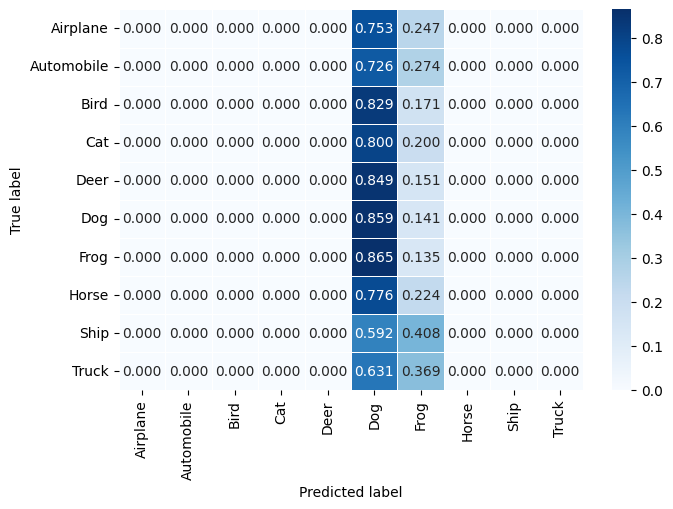

────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
     test_acc_epoch         0.0865885391831398
     test_loss_epoch           238412.515625
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


[{'test_loss_epoch': 238412.515625, 'test_acc_epoch': 0.0865885391831398}]

In [90]:
trainer.test(model=model, datamodule=data_module, verbose=True)

Total Incorrect Predictions 1403


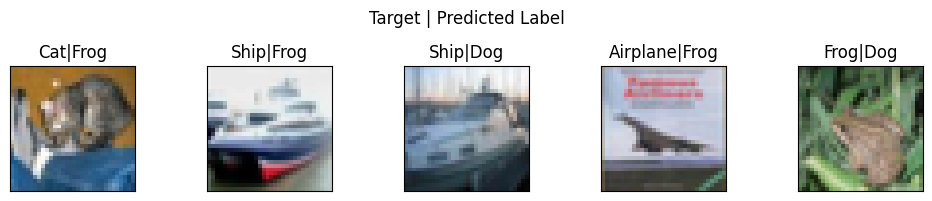

In [95]:
model.plot_incorrect_predictions_helper(num_imgs=5)

In [14]:
from torch.optim.lr_scheduler import OneCycleLR

EPOCHS = 24

scheduler = OneCycleLR(
        optimizer,
        max_lr=2.00E-03,
        steps_per_epoch=len(train_loader),
        epochs=EPOCHS,
        pct_start=5/EPOCHS,
        div_factor=100,
        three_phase=False,
        final_div_factor=100,
        anneal_strategy='linear'
    )

# Data to plot accuracy and loss graphs
train_losses = []
test_losses = []
train_accs = []
test_accs = []

for epoch in range(1, EPOCHS+1):
  print(f'Epoch {epoch}')
  train_accs, train_losses = train(model, device, train_loader, optimizer, criterion, scheduler, train_losses, train_accs)
  test_accs, test_losses = test(model, device, test_loader, criterion, test_losses, test_accs)

Epoch 1
Train: 100% Loss=1.3700 Batch_id=97 Accuracy=37.17
Test set: Average loss: 1.4286, Accuracy: 4981/10000 (49.81%)

Epoch 2
Train: 100% Loss=0.9111 Batch_id=97 Accuracy=60.19
Test set: Average loss: 0.9862, Accuracy: 6653/10000 (66.53%)

Epoch 3
Train: 100% Loss=0.7911 Batch_id=97 Accuracy=70.60
Test set: Average loss: 0.8489, Accuracy: 7104/10000 (71.04%)

Epoch 4
Train: 100% Loss=0.7288 Batch_id=97 Accuracy=75.67
Test set: Average loss: 0.7319, Accuracy: 7571/10000 (75.71%)

Epoch 5
Train: 100% Loss=0.6057 Batch_id=97 Accuracy=78.72
Test set: Average loss: 0.7781, Accuracy: 7429/10000 (74.29%)

Epoch 6
Train: 100% Loss=0.4106 Batch_id=97 Accuracy=80.97
Test set: Average loss: 0.4810, Accuracy: 8346/10000 (83.46%)

Epoch 7
Train: 100% Loss=0.4909 Batch_id=97 Accuracy=83.93
Test set: Average loss: 0.4627, Accuracy: 8418/10000 (84.18%)

Epoch 8
Train: 100% Loss=0.3857 Batch_id=97 Accuracy=85.09
Test set: Average loss: 0.4717, Accuracy: 8450/10000 (84.50%)

Epoch 9
Train: 100% Loss

In [15]:
import pandas as pd
bn_df = pd.DataFrame({'Train Acc': train_accs, 'Test Acc': test_accs, 'Train Loss': train_losses, 'Test Loss': test_losses})
bn_df.to_csv('Store/training_stats.csv', index=False)

In [16]:
import pandas as pd
bn_train = pd.read_csv("Store/training_stats.csv")
bn_train
train_accs = bn_train['Train Acc'].tolist()
test_accs = bn_train['Test Acc'].tolist()
train_losses = bn_train['Train Loss'].tolist()
test_losses = bn_train['Test Loss'].tolist()

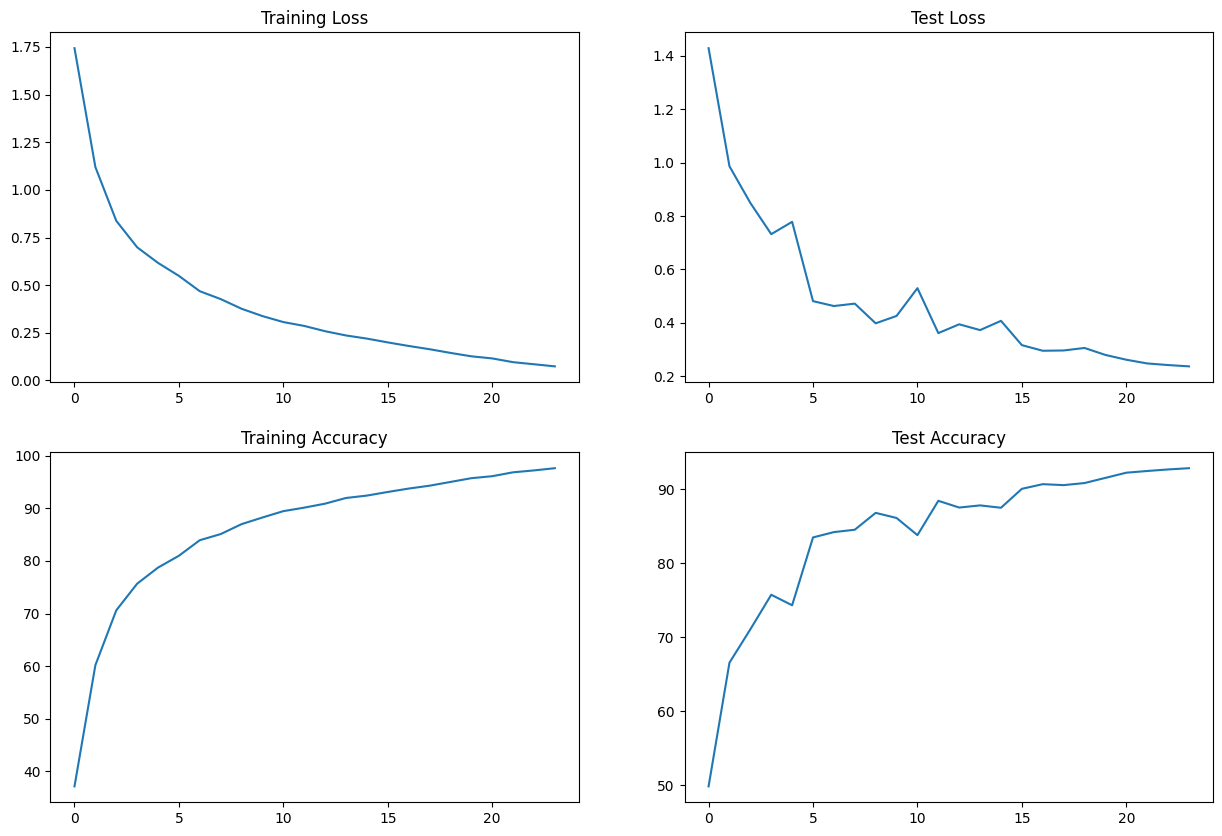

In [17]:
from Utilities.visualize import plot_model_training_curves

plot_model_training_curves(train_accs=train_accs, test_accs=test_accs, train_losses=train_losses, test_losses=test_losses)

# Model Analysis

/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:560: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


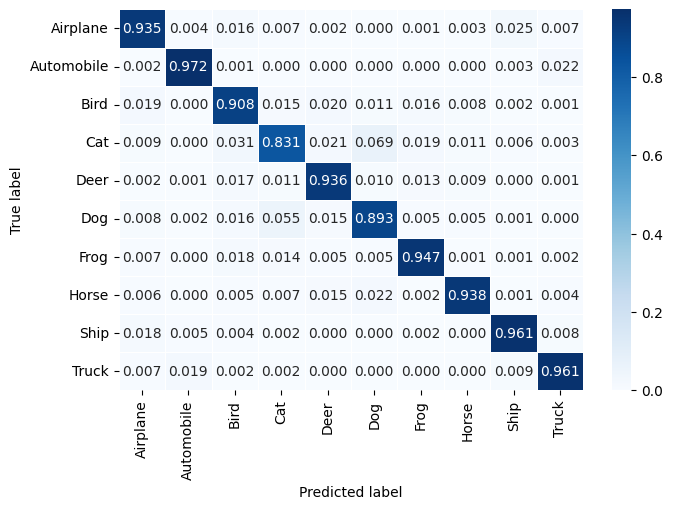

In [18]:
from Utilities.utils import get_all_and_incorrect_preds
from Utilities.visualize import plot_confusion_matrix

all_preds, all_labels, incorrect = get_all_and_incorrect_preds(model=model, loader=test_loader, device=device)
plot_confusion_matrix(all_labels, all_preds, classes=config.CLASSES)

Total Incorrect Predictions 718


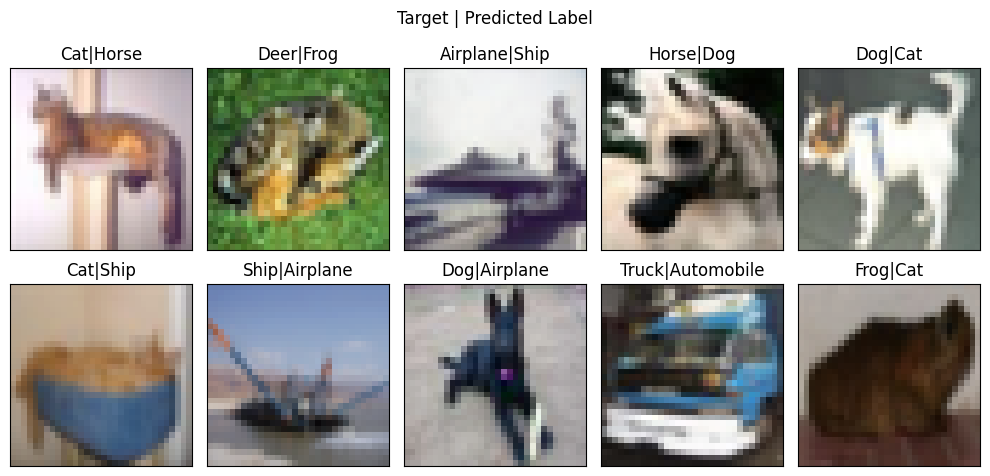

In [19]:
from Utilities.visualize import plot_incorrect_preds

plot_incorrect_preds(incorrect, classes=CLASSES)

### Git Push

In [22]:
!git add .
! git commit -m "S10 commit 92.82%"
! git push

[master aec4fcf] S10 commit 92.82%
 2 files changed, 27 insertions(+), 27 deletions(-)
 rewrite S10/Store/training_stats.csv (93%)
Enumerating objects: 13, done.
Counting objects: 100% (13/13), done.
Delta compression using up to 2 threads
Compressing objects: 100% (6/6), done.
Writing objects: 100% (7/7), 1.21 KiB | 310.00 KiB/s, done.
Total 7 (delta 3), reused 0 (delta 0)
remote: Resolving deltas: 100% (3/3), completed with 3 local objects.
To https://github.com/Madhur-1/ERA-v1
   3352787..aec4fcf  master -> master
